In [2]:
import requests
import matplotlib.pyplot as plt
import torch
import matplotlib.animation as animation
from IPython.display import display

https://www.geeksforgeeks.org/particle-swarm-optimization-pso-an-overview/  
https://github.com/mastqe/tsplib  
https://github.com/marcoscastro/tsp_pso/blob/master/references/paper.pdf  
https://www.codeproject.com/Articles/1182794/Solving-the-Travelling-Salesman-Problem-with-a-Par

In [3]:
response = requests.get("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/att48.tsp")
#print(response.text)

In [10]:
class TspParser:
    name: str
    dimension: int
    nodeCoordinates: dict
    coordinatesTensor: list

    def __init__(self, fileContent):
        self.nodeCoordinates = {}
        unprocessedData = fileContent.split("\n")
        isCoordinateSection = False
        for line in unprocessedData:
            line = line.strip()

            if "EOF" in line:
                break
            if "NAME" in line:
                nameData = line.split(":")
                self.name = nameData[1] if len(nameData) == 2 else None
            if "DIMENSION" in line:
                dimensionData = line.split(":")
                self.dimension = int(dimensionData[1]) if len(dimensionData) == 2 else None
                
            if isCoordinateSection:
                line = line.strip()
                stringData = line.split()
                nodeId = float(stringData[0])
                x = float(stringData[1])
                y = float(stringData[2])
                self.nodeCoordinates[nodeId] = (x, y)
                
            if "NODE_COORD_SECTION" in line:
                isCoordinateSection = True

        self.coordinatesTensor = torch.tensor(list(self.nodeCoordinates.values()), dtype=torch.float32)

att48 = TspParser(response.text)
print(att48.name, att48.dimension, att48.nodeCoordinates)
print(att48.coordinatesTensor)
        

 att48 48 {1.0: (6734.0, 1453.0), 2.0: (2233.0, 10.0), 3.0: (5530.0, 1424.0), 4.0: (401.0, 841.0), 5.0: (3082.0, 1644.0), 6.0: (7608.0, 4458.0), 7.0: (7573.0, 3716.0), 8.0: (7265.0, 1268.0), 9.0: (6898.0, 1885.0), 10.0: (1112.0, 2049.0), 11.0: (5468.0, 2606.0), 12.0: (5989.0, 2873.0), 13.0: (4706.0, 2674.0), 14.0: (4612.0, 2035.0), 15.0: (6347.0, 2683.0), 16.0: (6107.0, 669.0), 17.0: (7611.0, 5184.0), 18.0: (7462.0, 3590.0), 19.0: (7732.0, 4723.0), 20.0: (5900.0, 3561.0), 21.0: (4483.0, 3369.0), 22.0: (6101.0, 1110.0), 23.0: (5199.0, 2182.0), 24.0: (1633.0, 2809.0), 25.0: (4307.0, 2322.0), 26.0: (675.0, 1006.0), 27.0: (7555.0, 4819.0), 28.0: (7541.0, 3981.0), 29.0: (3177.0, 756.0), 30.0: (7352.0, 4506.0), 31.0: (7545.0, 2801.0), 32.0: (3245.0, 3305.0), 33.0: (6426.0, 3173.0), 34.0: (4608.0, 1198.0), 35.0: (23.0, 2216.0), 36.0: (7248.0, 3779.0), 37.0: (7762.0, 4595.0), 38.0: (7392.0, 2244.0), 39.0: (3484.0, 2829.0), 40.0: (6271.0, 2135.0), 41.0: (4985.0, 140.0), 42.0: (1916.0, 1569.0), 

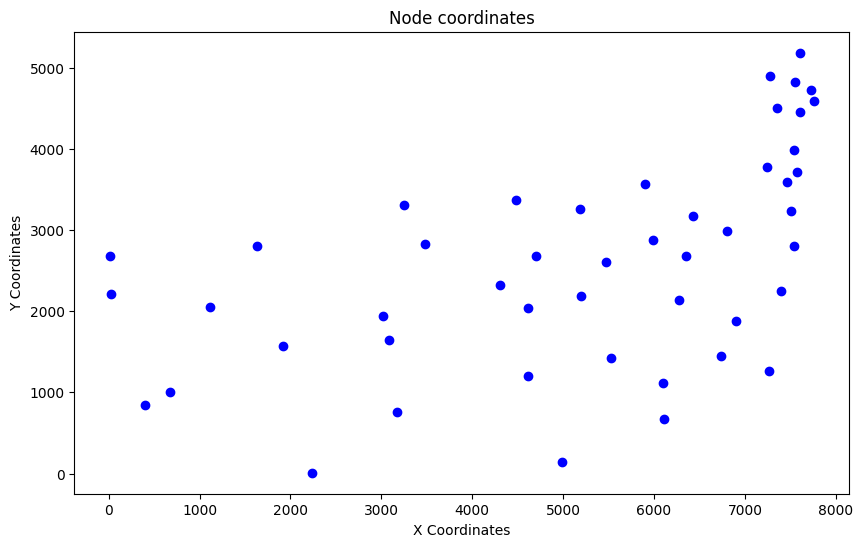

In [ ]:
def plot_coordinates(nodeCoordinates):
    #nodeIds = list(nodeCoordinates.keys())
    xCoords = [coord[0] for coord in nodeCoordinates.values()]
    yCoords = [coord[1] for coord in nodeCoordinates.values()]
    plt.figure(figsize=(10, 6))
    plt.scatter(xCoords, yCoords, c='blue', marker='o', label='Nodes')
    plt.xlabel('X Coordinates')
    plt.ylabel('Y Coordinates')
    plt.title('Node coordinates')
    plt.show()

plot_coordinates(att48.nodeCoordinates)

In [25]:
class Particle:
    def __init__(self, nodeCount):
        self.position = torch.randperm(nodeCount)
        self.fitnessValue = float("inf")
        self.localBestFitnessPosition = self.position.clone() 
        self.localBestFitnessValue = float("inf")
        self.velocity = torch.zeros(nodeCount)
        self.bestCost = float("inf")
    
    def evaluate(self, distance_matrix):
        tour = self.position.tolist() 
        total_distance = sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour)-1))
        total_distance += distance_matrix[tour[-1], tour[0]]
        self.fitnessValue = total_distance
        return total_distance


In [63]:


class ParticleSwarmOptimiser:
    def __init__(self, nodeCount, particleCount, inertia, particleCognition, socialInfluence, r1=1, r2=1):
        self.particleSwarm = [Particle(nodeCount) for _ in range(particleCount)]
        self.w = inertia
        self.c1 = particleCognition
        self.c2 = socialInfluence
        self.r1 = r1
        self.r2 = r2
        #self.minx = minx
        #self.maxx = maxx
        self.globalBestFitnessPosition = self.particleSwarm[0].position.clone()
        self.globalBestFitnessValue = float("inf")
        self.particleCount = particleCount
    
    def getBestSolution(self):
        return self.globalBestFitnessPosition, self.globalBestFitnessValue
    
    # def optimiseOld(self, maxIterations, distance_matrix):
    #     for _ in range(maxIterations):
    #         for i in range(self.particleCount):
    #             fitness = self.particleSwarm[i].evaluate(distance_matrix)
    #             self.particleSwarm[i].velocity = (self.w*self.particleSwarm[i].velocity +
    #                                              self.r1*self.c1*(self.particleSwarm[i].bestPos - self.particleSwarm[i].position) +
    #                                              self.r2*self.c2*( self.globalBestFitnessPosition - self.particleSwarm[i].position))
    #             self.particleSwarm[i].position += self.particleSwarm[i].velocity

    #             if self.particleSwarm[i].position < self.minx:
    #                 self.particleSwarm[i].position = self.minx
    #             elif self.particleSwarm[i].position > self.maxx:
    #                 self.particleSwarm[i].position = self.maxx
                    
    #             if self.particleSwarm[i].fitnessValue < self.particleSwarm[i].localBestFitnessValue:
    #                     self.particleSwarm[i].localBestFitnessValue = self.particleSwarm[i].fitnessValue
    #                     self.particleSwarm[i].localBestFitnessPosition = self.particleSwarm[i].position

    #             if self.particleSwarm[i].fitnessValue < self.globalBestFitnessValue:
    #                 self.globalBestFitnessValue = self.particleSwarm[i].fitnessValue
    #                 self.globalBestFitnessPosition = self.particleSwarm[i].position

    def optimise(self, distance_matrix, maxIterations):
        for _ in range(maxIterations):
            for particle in self.particleSwarm:
                fitness = particle.evaluate(distance_matrix)

                if fitness < particle.localBestFitnessValue:
                    particle.localBestFitnessValue = fitness
                    particle.localBestFitnessPosition = particle.position.clone()

                if fitness < self.globalBestFitnessValue:
                    self.globalBestFitnessValue = fitness
                    self.globalBestFitnessPosition = particle.position.clone()

            for particle in self.particleSwarm:
                new_position = self.apply_swap_mutation(particle.position.clone(), self.globalBestFitnessPosition)
                particle.position = new_position
                        
    def refine():
        #take in new hyperparameters without necessarily modifying particle swarm
        pass

    # def apply_swap_mutation(self, position, global_best):
    #     """
    #     Applies a swap-based mutation to move the particle towards the global best.
    #     This is used instead of vector-based velocity updates since TSP is a permutation problem.
    #     """
    #     if global_best is None:
    #         return position  # No global best found yet

    #     swap_indices = torch.randperm(len(position))[:2]  # Pick two random indices
    #     i, j = swap_indices[0].item(), swap_indices[1].item()
    #     position[i], position[j] = position[j], position[i]  # Swap the two cities
    #     return position

    def apply_swap_mutation(self, position, global_best):
        if global_best is None:
            return position  # No global best found yet

        # 🔹 Swap mutation with controlled probability
        mutation_prob = 0.3  # Reduce randomness to avoid bad mutations
        if torch.rand(1).item() < mutation_prob:
            swap_indices = torch.randperm(len(position))[:2]  # Pick two random indices
            i, j = swap_indices[0].item(), swap_indices[1].item()
            position[i], position[j] = position[j], position[i]  # Swap the two cities
        
        # 🔹 Partial Crossover with Global Best (More Guidance)
        cross_prob = 0.5
        if torch.rand(1).item() < cross_prob:
            cut_point = torch.randint(1, len(position)-1, (1,)).item()
            position[:cut_point] = global_best[:cut_point]  # Align early parts with global best
        
        return position
        

In [64]:
def compute_distance_matrix(coordinatesTensor):
    nodeCount = coordinatesTensor.shape[0]
    distance_matrix = torch.zeros((nodeCount, nodeCount))

    for i in range(nodeCount):
        for j in range(nodeCount):
            if i != j:
                distance_matrix[i, j] = torch.norm(coordinatesTensor[i] - coordinatesTensor[j]) 
    return distance_matrix

clean up code

modify the optimiser to work

tune hyperparameters

visualise each stage

use torch features throughout code

use more problem types, or do a comparison with a different type of optimisation e.g. ant colony

Actually what im thinking now is to make a neural network which is trained on the data and solutions, or trained based on past runs of the PSO, then train it to predict which hyperparameter values to use.

In [73]:
distance_matrix = compute_distance_matrix(att48.coordinatesTensor)
#print(distance_matrix)
particle_count = 20
max_iterations = 500
inertia = 0.8
c1 = 1.5
c2 = 1.5

# Initialize PSO
pso = ParticleSwarmOptimiser(
    nodeCount=att48.dimension,
    particleCount=particle_count,
    inertia=inertia,
    particleCognition=c1,
    socialInfluence=c2
)

pso.optimise(distance_matrix, max_iterations)
best_path, best_cost = pso.getBestSolution()

print("\nBest Path Found:", best_path.tolist())
print("Best Cost:", best_cost)


Best Path Found: [12, 12, 22, 13, 2, 13, 22, 2, 21, 33, 33, 32, 8, 8, 7, 27, 17, 12, 12, 12, 12, 12, 29, 27, 27, 12, 12, 12, 39, 8, 39, 39, 38, 38, 38, 38, 46, 46, 13, 13, 33, 22, 2, 2, 2, 22, 12, 12]
Best Cost: tensor(38106.5742)
